In [ ]:
#Code sourced from following links
#https://github.com/sarthak25/Brain-tumor-segmentation
#https://github.com/karolzak/keras-unet/tree/master/keras_unet
#https://github.com/MohamedAliHabib/Brain-Tumor-Detection
#https://github.com/charan223/Brain-Tumor-Segmentation-using-Topological-Loss
#https://github.com/sdsubhajitdas/Brain-Tumor-Segmentation
#https://github.com/Mehrdad-Noori/Brain-Tumor-Segmentation
#https://github.com/yunyuntsai/BraTS-brain-tumer-segmentation/blob/master/Seg_net.ipynb
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Input, merge, UpSampling2D,BatchNormalization
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
#import tensorflow as tf

import matplotlib.pyplot as plt
import skimage.io as io
from glob import glob

import numpy as np
import random as r
import cv2

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tf.__version__

'2.8.0'

In [ ]:
!pip install simpleitk

     |████████████████████████████████| 48.4 MB 1.2 MB/s 


In [ ]:
path = "/content/drive/My Drive/Dataset/COVIDCT/"

In [ ]:
files = glob(path+"tr_im.nii.gz")

len(files)

1

# Convert to Array

In [ ]:
first_img = io.imread(files[0], plugin="simpleitk")

print(f"shape: {first_img.shape}")
print(f"dtype: {first_img.dtype}")

shape: (100, 512, 512)
dtype: float64


## Visualize Flair Image

Text(0.5, 1.0, 'axial (transverse) plane')

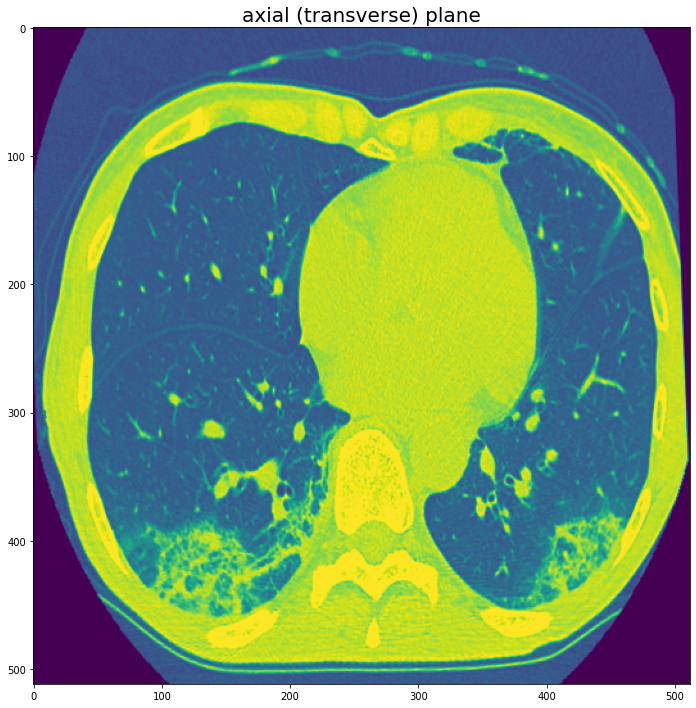

In [ ]:
fig = plt.figure(figsize=(40,30))

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(first_img[35,:,:])
plt.title("axial (transverse) plane", fontsize=20)



## Visualize Segmented Image

In [ ]:
files[0]

'/content/drive/My Drive/Dataset/HGG/Subset/BraTS19_TMC_06290_1/BraTS19_TMC_06290_1_flair.nii.gz'

In [ ]:
seg_img = io.imread('/content/drive/My Drive/Dataset/COVIDCT/tr_mask.nii.gz', plugin="simpleitk")

print(f"shape: {seg_img.shape}")
print(f"dtype: {seg_img.dtype}")

shape: (100, 512, 512)
dtype: float64


Text(0.5, 1.0, 'segmentation for axial (transverse) plane')

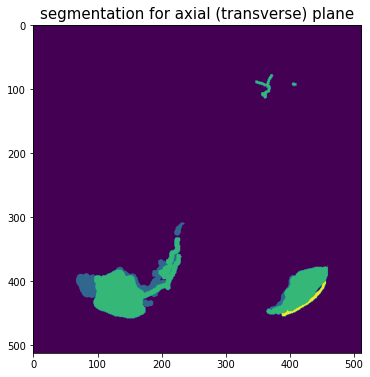

In [ ]:
fig = plt.figure(figsize=(20,15))

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(seg_img[35,:,:])
plt.title("segmentation for axial (transverse) plane", fontsize=15)



# Convert to Array 

In [ ]:
def to_array(path, end):
    
    # get locations
    files = glob(path+end, recursive=True)
    
    img_list = []
    
    r.seed(42)
    r.shuffle(files)
    
    for file in files:
        img = io.imread(file, plugin="simpleitk")

        # standardization
        img = (img-img.mean())/img.std()
        img.astype("float32")
        
        for slice in range(0, 100):
            img_s = img[slice,:,:]
            
            # resize
            img_s = cv2.resize(img_s, (256,256))
            
            img_s = np.expand_dims(img_s, axis=0)
            img_list.append(img_s)
            
    return np.array(img_list,np.float32)

### np.expand_dims()

In [ ]:
first_img.shape

(100, 512, 512)

In [ ]:
exp = first_img[60,:,:]

exp.shape

(512, 512)

In [ ]:
exp = np.expand_dims(exp, axis=0)

exp.shape

(1, 512, 512)

# Applying the Function

In [ ]:
train = to_array(path=path, end="tr_im.nii.gz")

In [ ]:
train.shape

(100, 1, 256, 256)

In [ ]:
plt.imshow(train[55].reshape(512,512))
plt.title("train: 55");

ValueError: ignored

In [ ]:
t1ce = to_array(path=path, end='**/*t1ce.nii.gz')

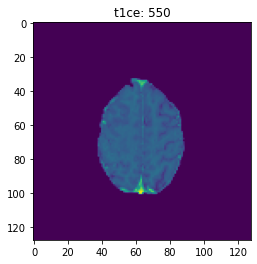

In [ ]:
plt.imshow(t1ce[550].reshape(128,128))
plt.title("t1ce: 550");

# Segmented Images

1 - Non-enhancing Tumor

2 - Edema 

4 - Enhancing Tumor

In [ ]:
seg_img.shape

(100, 512, 512)

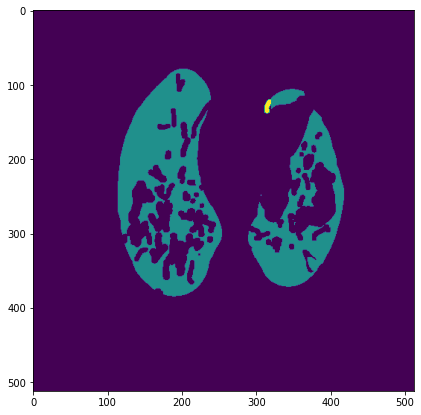

In [ ]:
plt.figure(figsize=(7,7))
plt.imshow(seg_img[55,:,:]);

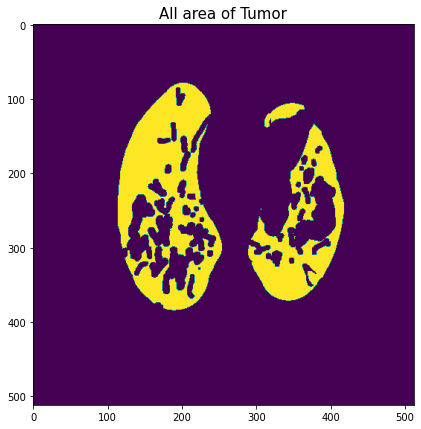

In [ ]:
seg_all = seg_img.copy()

seg_all[seg_all != 0] = 1 # show all tumor area

plt.figure(figsize=(7,7))
plt.imshow(seg_all[55,:,:])
plt.title("All area of Tumor", fontsize=15);

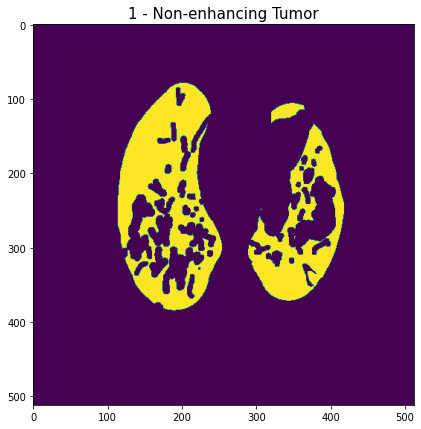

In [ ]:
seg_non = seg_img.copy()

seg_non[seg_non != 1] = 0 # show non-enhancing tumor

plt.figure(figsize=(7,7))
plt.imshow(seg_non[55,:,:])
plt.title("1 - Non-enhancing Tumor", fontsize=15);

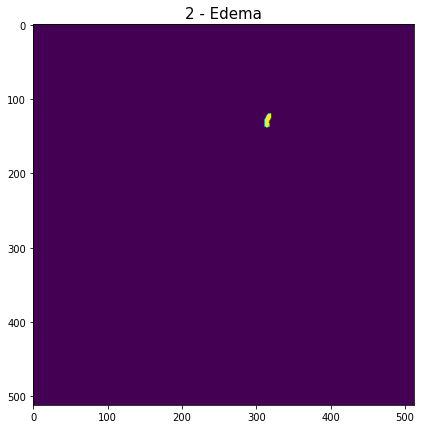

In [ ]:
seg_edema = seg_img.copy()

seg_edema[seg_edema == 1] = 0 # cover Non-enhancing Tumor
seg_edema[seg_edema == 4] = 0 # cover Enhancing Tumor
seg_edema[seg_edema != 0] = 1 # show Edema

plt.figure(figsize=(7,7))
plt.imshow(seg_edema[55,:,:])
plt.title("2 - Edema", fontsize=15);

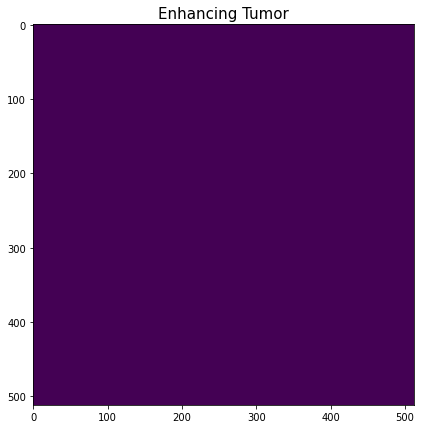

In [ ]:
seg_enhancing = seg_img.copy()

seg_enhancing[seg_enhancing != 4] = 0 # show Enhancing Tumor

plt.figure(figsize=(7,7))
plt.imshow(seg_enhancing[55,:,:])
plt.title("Enhancing Tumor", fontsize=15);

# To Array for Segmented Images

In [ ]:
def image_to_array(path, end, label):
    
    # get locations
    files = glob(path+end, recursive=True)
    
    img_list = []
    
    r.seed(42)
    r.shuffle(files)
    
    for file in files:
        img = io.imread(file, plugin="simpleitk")
        
        # all tumor
        if label == 1:
            img[img != 0] = 1
        
        # Non-enhancing Tumor
        if label == 2:
            img[img != 1] = 0
        
        # Without Edema
        if label == 3:
            img[img == 2] = 0
            img[img != 0] = 1
        
        # Enhancing Tumor
        if label == 4:
            img[img != 4] = 0
            img[img == 4] = 1
            

        img.astype("float32")
        
        for slice in range(0, 100):
            img_s = img[slice,:,:]
            
            # resize
            img_s = cv2.resize(img_s, (256,256))
            
            img_s = np.expand_dims(img_s, axis=0)
            img_list.append(img_s)
            
    return np.array(img_list,np.float32)

In [ ]:
seg_all_tumor = image_to_array(path=path, end="tr_mask.nii.gz", label=1)

#seg_non_enhancing = image_to_array(path=path, end="**/*seg.nii.gz", label=2)

#seg_out_edema = image_to_array(path=path, end="**/*seg.nii.gz", label=3) 

#seg_enhancing = image_to_array(path=path, end="**/*seg.nii.gz", label=4) 

#seg_original = image_to_array(path=path, end="**/*seg.nii.gz", label=0)

In [ ]:
seg_all_tumor.shape

(100, 1, 256, 256)

In [ ]:
seg_non_enhancing.shape

(36260, 1, 128, 128)

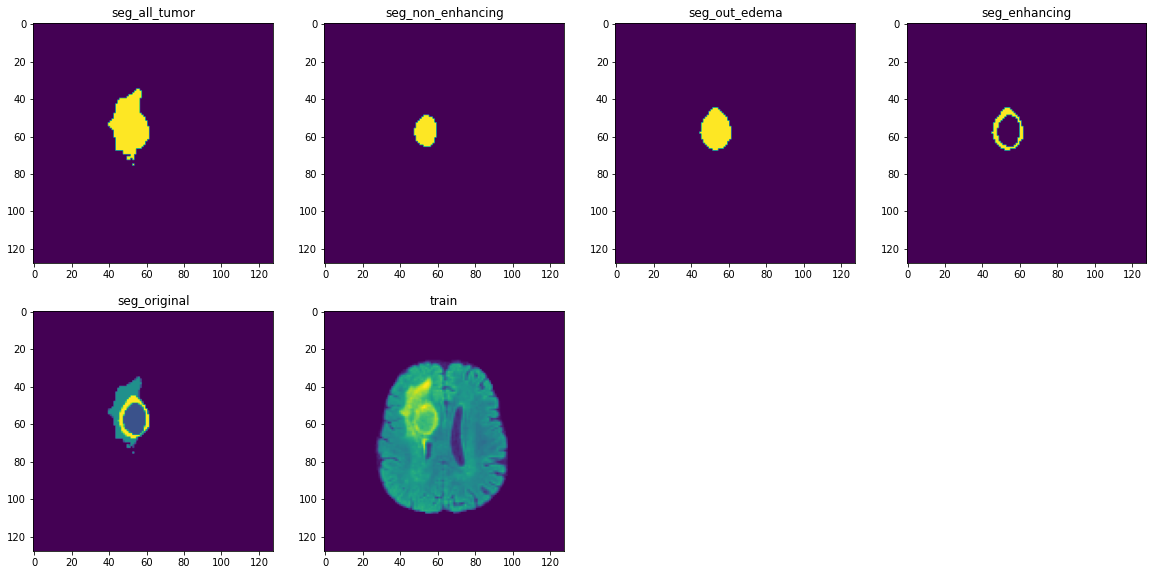

In [ ]:
idx = 100

plt.figure(figsize=(20,15))

plt.subplot(3,4,1)
plt.imshow(seg_all_tumor[idx].reshape(128,128))
plt.title("seg_all_tumor")

plt.subplot(3,4,2)
plt.imshow(seg_non_enhancing[idx].reshape(128,128))
plt.title("seg_non_enhancing")

plt.subplot(3,4,3)
plt.imshow(seg_out_edema[idx].reshape(128,128))
plt.title("seg_out_edema")

plt.subplot(3,4,4)
plt.imshow(seg_enhancing[idx].reshape(128,128))
plt.title("seg_enhancing")

plt.subplot(3,4,5)
plt.imshow(seg_original[idx].reshape(128,128))
plt.title("seg_original")

plt.subplot(3,4,6)
plt.imshow(train[idx].reshape(128,128))
plt.title("train");

# U-NET MODEL

In [ ]:
flair = to_array(path=path, end="**/*flair.nii.gz")
t2 = to_array(path=path, end="**/*t2.nii.gz")
#seg = image_to_array(path=path, end="**/*seg.nii.gz", label=1)


In [ ]:
flair.shape, t2.shape, seg.shape

((18130, 1, 128, 128), (18130, 1, 128, 128), (18130, 1, 128, 128))

## Concatenate

In [ ]:
X_train = np.concatenate((flair, t2, t1ce), axis=1)

In [ ]:
X_train = train

In [ ]:
X_train.shape

(100, 1, 256, 256)

In [ ]:
X_train.dtype

dtype('float32')

# U-NET MODEL

In [ ]:
from tensorflow.keras.metrics import binary_crossentropy
from tensorflow.keras.metrics import AUC
from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import Recall
from tensorflow.keras.metrics import MeanIoU



In [ ]:
def dice_coef(y_true, y_pred):
    smooth = 0.005 
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou(y_true, y_pred):
    smooth = 0.005 
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (union + smooth)





def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)
    

K.set_image_data_format('channels_first')

from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=200, verbose=2)


def unet():
    
    inputs = Input((1, 256 , 256))
    
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (inputs)
    batch1 = BatchNormalization(axis=1)(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D((2, 2))(batch1)
    
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (pool1)
    batch2 = BatchNormalization(axis=1)(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D((2, 2))(batch2)
    
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (pool2)
    batch3 = BatchNormalization(axis=1)(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D((2, 2))(batch3)
    
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same') (pool3)
    batch4 = BatchNormalization(axis=1)(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch4)
    batch4 = BatchNormalization(axis=1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(batch4)

   # conv41 = Conv2D(1024, (3, 3), activation='relu', padding='same') (pool4)
   # batch41 = BatchNormalization(axis=1)(conv41)
   # conv41 = Conv2D(1024, (3, 3), activation='relu', padding='same') (batch41)
   # batch41 = BatchNormalization(axis=1)(conv41)
   # pool41 = MaxPooling2D(pool_size=(2, 2))(batch41)
    
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (pool4)
    batch5 = BatchNormalization(axis=1)(conv5)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (batch5)
    batch5 = BatchNormalization(axis=1)(conv5)

   # up5 = Conv2DTranspose(1024, (2, 2), strides=(2, 2), padding='same') (batch5)
   # up5 = concatenate([up5, conv41], axis=1)
   # conv61 = Conv2D(1024, (3, 3), activation='relu', padding='same') (up5)
   # batch61 = BatchNormalization(axis=1)(conv61)
   # conv61 = Conv2D(1024, (3, 3), activation='relu', padding='same') (batch61)
   # batch61 = BatchNormalization(axis=1)(conv61)
    
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (batch5)
    up6 = concatenate([up6, conv4], axis=1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same') (up6)
    batch6 = BatchNormalization(axis=1)(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch6)
    batch6 = BatchNormalization(axis=1)(conv6)
    
    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (batch6)
    up7 = concatenate([up7, conv3], axis=1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (up7)
    batch7 = BatchNormalization(axis=1)(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch7)
    batch7 = BatchNormalization(axis=1)(conv7)
    
    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (batch7)
    up8 = concatenate([up8, conv2], axis=1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (up8)
    batch8 = BatchNormalization(axis=1)(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch8)
    batch8 = BatchNormalization(axis=1)(conv8)
    
    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (batch8)
    up9 = concatenate([up9, conv1], axis=1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (up9)
    batch9 = BatchNormalization(axis=1)(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(batch9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_coef_loss, metrics=[dice_coef, iou, 'accuracy', 'Precision', 'Recall'])

    return model

In [ ]:
model = unet()
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 1, 256, 256  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_247 (Conv2D)            (None, 64, 256, 256  640         ['input_14[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_234 (Batch  (None, 64, 256, 256  256        ['conv2d_247[0][0]']             
 Normalization)                 )                                                          

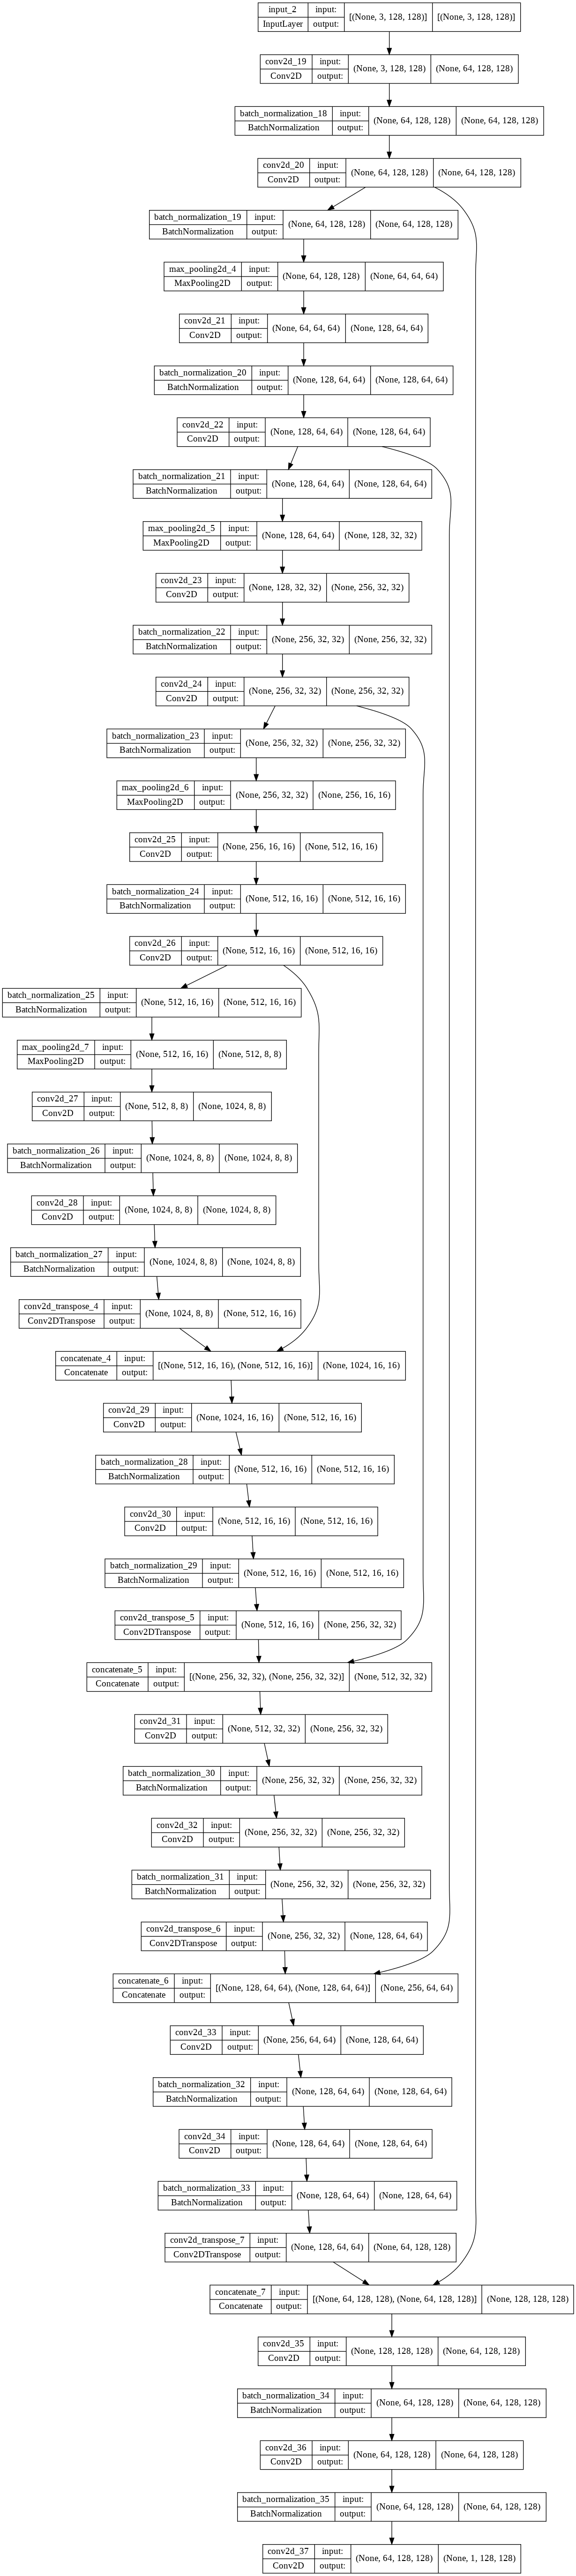

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.fit(X_train, seg_all_tumor, validation_split=0.25, batch_size=32, epochs=1000, shuffle=True, callbacks=[early_stopping])

Epoch 1/1000
3/3 [==============================] - 6s 1s/step - loss: 0.8417 - dice_coef: 0.1622 - iou: 0.0889 - accuracy: 0.0226 - precision: 0.1121 - recall: 0.6945 - val_loss: 0.8796 - val_dice_coef: 0.1204 - val_iou: 0.0640 - val_accuracy: 0.1433 - val_precision: 0.0291 - val_recall: 0.3028
Epoch 2/1000
3/3 [==============================] - 2s 712ms/step - loss: 0.7639 - dice_coef: 0.2605 - iou: 0.1513 - accuracy: 0.0539 - precision: 0.1741 - recall: 0.9394 - val_loss: 0.8791 - val_dice_coef: 0.1209 - val_iou: 0.0643 - val_accuracy: 0.2445 - val_precision: 0.0287 - val_recall: 0.0047
Epoch 3/1000
3/3 [==============================] - 2s 712ms/step - loss: 0.7303 - dice_coef: 0.2560 - iou: 0.1474 - accuracy: 0.0761 - precision: 0.2043 - recall: 0.9557 - val_loss: 0.8786 - val_dice_coef: 0.1214 - val_iou: 0.0646 - val_accuracy: 0.3509 - val_precision: 0.0022 - val_recall: 1.6545e-05
Epoch 4/1000
3/3 [==============================] - 2s 713ms/step - loss: 0.7006 - dice_coef: 0.271

In [ ]:
model.save_weights("/content/drive/MyDrive/Dataset/subset_model.h5")

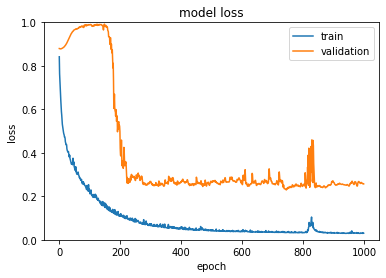

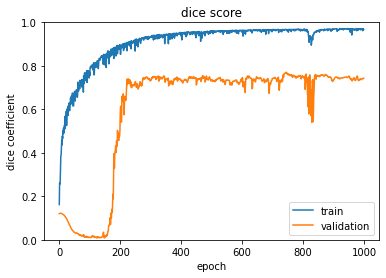

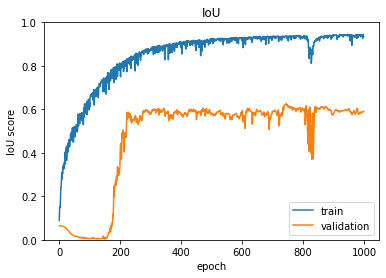

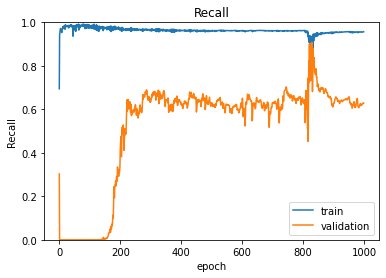

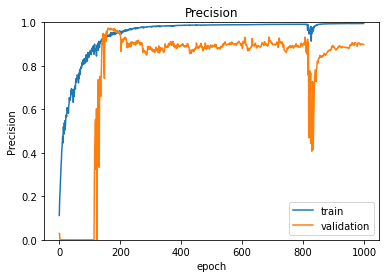

In [ ]:

plt.plot(model.history.history['loss'])

plt.plot(model.history.history['val_loss'])
plt.legend(['train', 'validation'], loc='upper right')
plt.ylim(0, 1)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('model loss')
plt.show()





plt.plot(model.history.history['dice_coef'])
plt.plot(model.history.history['val_dice_coef'])
plt.title('dice score')
plt.ylim(0, 1)
plt.xlabel('epoch')
plt.ylabel('dice coefficient')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

plt.plot(model.history.history['iou'])
plt.plot(model.history.history['val_iou'])
plt.ylim(0, 1)
plt.title('IoU')
plt.xlabel('epoch')
plt.ylabel('IoU score')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

plt.plot(model.history.history['recall'])
plt.plot(model.history.history['val_recall'])
plt.ylim(0, 1)
plt.title('Recall')
plt.xlabel('epoch')
plt.ylabel('Recall')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

plt.plot(model.history.history['precision'])
plt.plot(model.history.history['val_precision'])
plt.ylim(0, 1)
plt.title('Precision')
plt.xlabel('epoch')
plt.ylabel('Precision')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

# PREDICTION

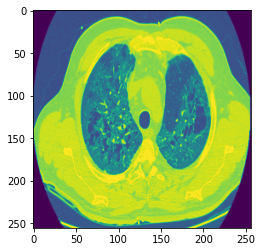

In [ ]:
plt.imshow(X_train[55][0]);

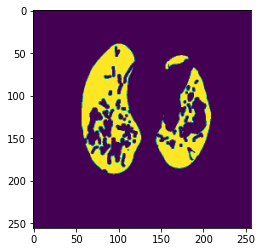

In [ ]:
plt.imshow(seg_all_tumor[55][0]);

In [ ]:
pred_list = []
for i in range(0,100):
  expand_img = np.expand_dims(X_train[i], axis=0)
  pred = model.predict(expand_img)
  pred.flatten()
  pred_list.append(pred)

In [ ]:
pred_list = np.array(pred_list,np.float32)
pred_list.shape

(100, 1, 1, 256, 256)

In [ ]:
pred_list = np.concatenate(pred_list, axis=0)
pred_list.shape

(6553600,)

In [ ]:
for i in range(1000000,1000100):
  print(pred_list[i])

0.0026232456
0.0029579124
0.0034383393
0.0039085886
0.0034325027
0.0030727438
0.0035020437
0.0036807044
0.003488652
0.003185312
0.003434572
0.0028199204
0.0024430614
0.0017748863
0.0018956864
0.0017443997
0.0016594732
0.0015133258
0.0014233143
0.0013668024
0.001602022
0.001611253
0.00195501
0.0022305492
0.00234277
0.0031010292
0.0029028514
0.0033679148
0.0024559163
0.00327388
0.0023074578
0.003116848
0.0019498987
0.0027883414
0.0027069524
0.0030259802
0.0020650397
0.0023477336
0.0021404985
0.0027856578
0.001796315
0.0025310654
0.002189096
0.0027754358
0.0020225805
0.00253243
0.0021115858
0.0027159953
0.002013794
0.0024948225
0.0022819908
0.002592265
0.0019649642
0.0023659416
0.0021720529
0.0026574878
0.0022239455
0.0026806234
0.0024449262
0.0027626597
0.0020993154
0.0027730283
0.0023479192
0.0027466058
0.002213678
0.0028220075
0.0026140073
0.0030135908
0.0021725367
0.0027755203
0.0023510251
0.002747498
0.002227706
0.0026838814
0.0024333794
0.0027909891
0.0021407856
0.0025506527
0.00220

In [ ]:
seg_all_tumor2 = np.concatenate(seg_all_tumor, axis=0)
seg_all_tumor2.shape

(100, 256, 256)

In [ ]:
seg_all_tumor2 = np.concatenate(seg_all_tumor2, axis=0)
seg_all_tumor2.shape

(6553600,)

In [ ]:
for i in range(1000000,1000100):
  print(seg_all_tumor2[i])

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


## Visualize Prediction

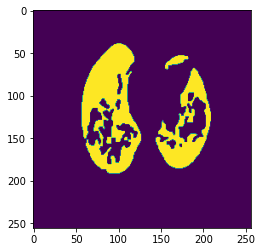

In [ ]:
plt.imshow(pred[0][0]);

In [ ]:
from sklearn.metrics import roc_curve, auc # roc curve tools
ground_truth_labels = seg_all_tumor2.flatten() # we want to make them into vectors
score_value =  pred_list.flatten()# we want to make them into vectors
fpr, tpr, _ = roc_curve(ground_truth_labels,score_value)
roc_auc = auc(fpr,tpr)

fig, ax = plt.subplots(1,1)
ax.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
ax.legend(loc="lower right")

ValueError: ignored

tf.Tensor(0.6747539, shape=(), dtype=float32)


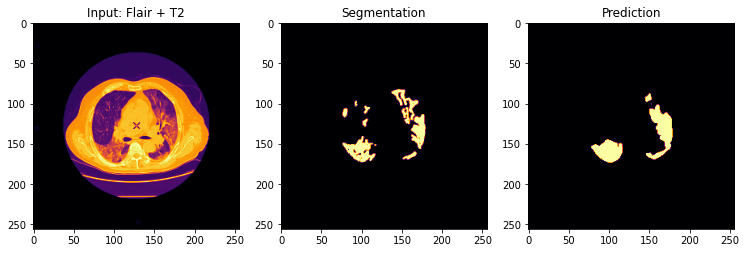

In [ ]:
x = 95

sample = np.expand_dims(X_train[x], axis=0)
pred = model.predict(sample)


fig = plt.figure(figsize=(17, 15))

plt.subplot(1,4,1)
plt.title("Input: Flair + T2")
plt.imshow(X_train[x][0], cmap="inferno")

plt.subplot(1,4,2)
plt.title("Segmentation")
plt.imshow(seg_all_tumor[x][0], cmap="inferno")

plt.subplot(1,4,3)
plt.title("Prediction")
plt.imshow(pred[0][0], cmap="inferno");

results = 0
for i in range(70,100):
  sample = np.expand_dims(X_train[i], axis=0)
  pred = model.predict(sample)
  results += dice_coef(seg_all_tumor[i][0],pred[0][0])

print(results/30)


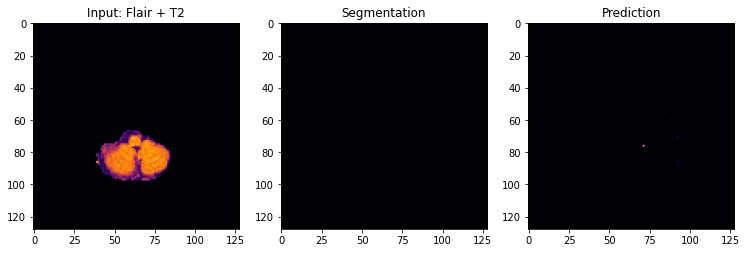

In [ ]:
x = 400

sample = np.expand_dims(X_train[x], axis=0)
pred = model.predict(sample)


fig = plt.figure(figsize=(17, 15))

plt.subplot(1,4,1)
plt.title("Input: Flair + T2")
plt.imshow(X_train[x][0], cmap="inferno")

plt.subplot(1,4,2)
plt.title("Segmentation")
plt.imshow(seg_all_tumor[x][0], cmap="inferno")

plt.subplot(1,4,3)
plt.title("Prediction")
plt.imshow(pred[0][0], cmap="inferno");

# Cropping Images

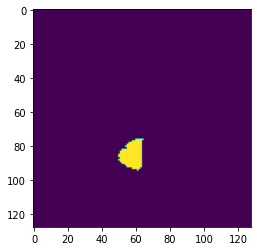

In [ ]:
tmp = seg_out_edema[666,0,:,:]

tmp.shape

plt.imshow(tmp);

In [ ]:
# threshold
tmp[tmp > 0.2] = 1
tmp[tmp != 1] = 0

In [ ]:
index_xy = np.where(tmp==1)

In [ ]:
index_xy[0]

array([76, 76, 76, 76, 76, 77, 77, 77, 77, 77, 77, 78, 78, 78, 78, 78, 78,
       78, 78, 79, 79, 79, 79, 79, 79, 79, 79, 79, 80, 80, 80, 80, 80, 80,
       80, 80, 80, 80, 81, 81, 81, 81, 81, 81, 81, 81, 81, 82, 82, 82, 82,
       82, 82, 82, 82, 82, 82, 82, 82, 83, 83, 83, 83, 83, 83, 83, 83, 83,
       83, 83, 83, 83, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84,
       85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 86, 86, 86,
       86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 87, 87, 87, 87, 87, 87,
       87, 87, 87, 87, 87, 87, 87, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88,
       88, 88, 88, 88, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89,
       90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 91, 91, 91, 91, 91,
       91, 91, 91, 91, 91, 92, 92, 92, 92, 92, 92, 92, 92, 92, 93, 93, 93,
       93, 93, 94])

In [ ]:
index_xy[1]

array([60, 61, 62, 63, 64, 58, 59, 60, 61, 62, 63, 56, 57, 58, 59, 60, 61,
       62, 63, 55, 56, 57, 58, 59, 60, 61, 62, 63, 54, 55, 56, 57, 58, 59,
       60, 61, 62, 63, 55, 56, 57, 58, 59, 60, 61, 62, 63, 52, 53, 54, 55,
       56, 57, 58, 59, 60, 61, 62, 63, 51, 52, 53, 54, 55, 56, 57, 58, 59,
       60, 61, 62, 63, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
       50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 51, 52, 53, 54, 55, 56,
       57, 58, 59, 60, 61, 62, 63, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
       60, 61, 62, 63, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 55, 56, 57, 58, 59, 60, 61, 62, 63, 58, 59, 60,
       61, 62, 61])

In [ ]:
center_y = (max(index_xy[0]) + min(index_xy[0])) / 2

center_y

85.0

In [ ]:
center_x = (max(index_xy[1]) + min(index_xy[1])) / 2

center_x

57.0

In [ ]:
img_x = np.zeros((64,64), np.float32)

img_x.shape

(64, 64)

In [ ]:
x = t1ce[666,0,:,:]
x.shape

(128, 128)

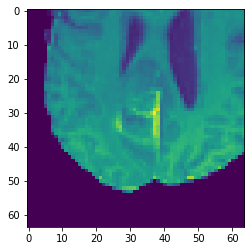

In [ ]:
img_x[:,:] = x[int(center_y - 64/2): int(center_y + 64/2), int(center_x - 64/2): int(center_x + 64/2)]


plt.imshow(img_x);

In [ ]:
seg_ = seg_out_edema[666,0,:,:]

seg_.shape

(128, 128)

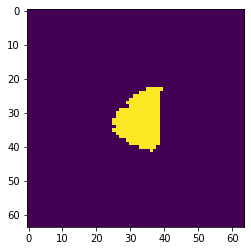

In [ ]:
img_x[:,:] = seg_[int(center_y - 64/2): int(center_y + 64/2), int(center_x - 64/2): int(center_x + 64/2)]


plt.imshow(img_x);

In [ ]:
def crop_tumor(mr, seg):
  
  mr = mr[0]
  list_ = []

  # thresholding
  tmp = seg[0,:,:]
  tmp[tmp > 0.2] = 1
  tmp[tmp != 1] = 0
  index_xy = np.where(tmp==1)

  # some images contain no tumor !
  if index_xy[0] != []:

    center_y = (max(index_xy[0]) + min(index_xy[0])) / 2
    center_x = (max(index_xy[1]) + min(index_xy[1])) / 2

    img_x = np.zeros((64,64), np.float32)

    img_x[:,:] = mr[int(center_y - 64/2):int(center_y + 64/2), int(center_x - 64/2):int(center_x + 64/2)]

    list_.append(img_x)
  
  return np.array(list_)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  del sys.path[0]


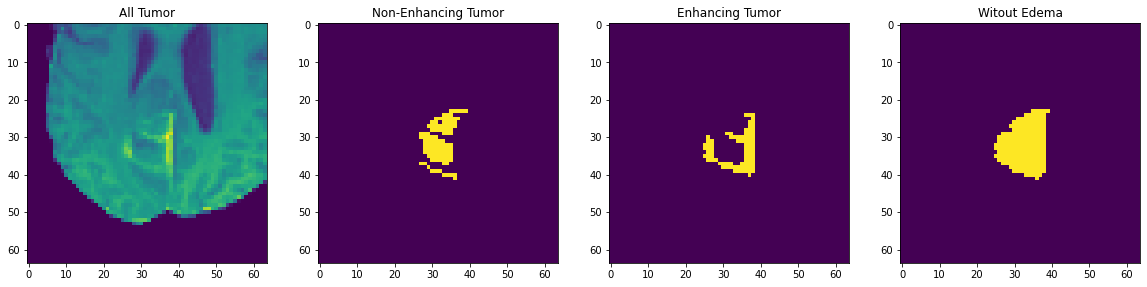

In [ ]:
img_666 = crop_tumor(mr=t1ce[666], seg=seg_out_edema[666])
non_666 = crop_tumor(mr=seg_non_enhancing[666], seg=seg_out_edema[666])
enhancing_666 = crop_tumor(mr=seg_enhancing[666], seg=seg_out_edema[666])
without_edema_666 = crop_tumor(mr=seg_out_edema[666], seg=seg_out_edema[666])


plt.figure(figsize=(20,15))

plt.subplot(3,4,1)
plt.imshow(img_666[0])
plt.title("All Tumor")

plt.subplot(3,4,2)
plt.imshow(non_666[0])
plt.title("Non-Enhancing Tumor")

plt.subplot(3,4,3)
plt.imshow(enhancing_666[0])
plt.title("Enhancing Tumor")

plt.subplot(3,4,4)
plt.imshow(without_edema_666[0])
plt.title("Witout Edema");